# Actividad 3: Evaluación de la segmentación.

**Alumnos:** Pablo García Catalán.<br>
**Asignatura:** Percepción computacional 2020-21.<br>
**Enlace repositorio:** https://github.com/p-g-c/pc_actividad3 <br>

**Índice:** <br>

1. Planteamiento de la actividad<br>
2. Pruebas con algoritmos de segmentación<br>
    2.1 Watershed<br>
    2.2 Watershed con grafos<br>
    2.3 Quickshift con grafos<br>
    2.4 Contornos activos geodésicos<br>
    2.5 Simple linear interactive clustering (SLIC)<br>
3. Evaluación de algoritmos<br>
4. Conclusiones<br>






#### 1.- Planteamiento de la actividad.
Para la realización de esta actividad se han seleccionado seis muestras del dataset <a href="https://data.mendeley.com/datasets/hb74ynkjcn/1">10.17632/hb74ynkjcn.1</a>. La finalidad es simplemente separar las hojas del fondo para facilitar la extracción de sus características. Para esta tarea, se han utilizado diferentes técnicas de segmentación para al final evaluarlas utilizando las métricas habituales de algoritmos de clasificación.<br>


In [2]:
# En primer lugar se importar las librerías a uyilizar
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn import metrics
import numpy as np
import math
import time
from skimage import data, io, exposure, img_as_float, color,morphology,measure,img_as_ubyte,segmentation,feature
from skimage.color import rgb2hsv,rgb2gray,rgba2rgb
from skimage.filters import threshold_otsu,threshold_mean,try_all_threshold,threshold_li,threshold_minimum,laplace,median,sobel,gaussian
from skimage.feature import peak_local_max,canny
from skimage.future import graph
from skimage.measure import label
from skimage.segmentation import (slic,watershed,morphological_chan_vese,
morphological_geodesic_active_contour, felzenszwalb, mark_boundaries,
inverse_gaussian_gradient,
checkerboard_level_set, quickshift,active_contour)

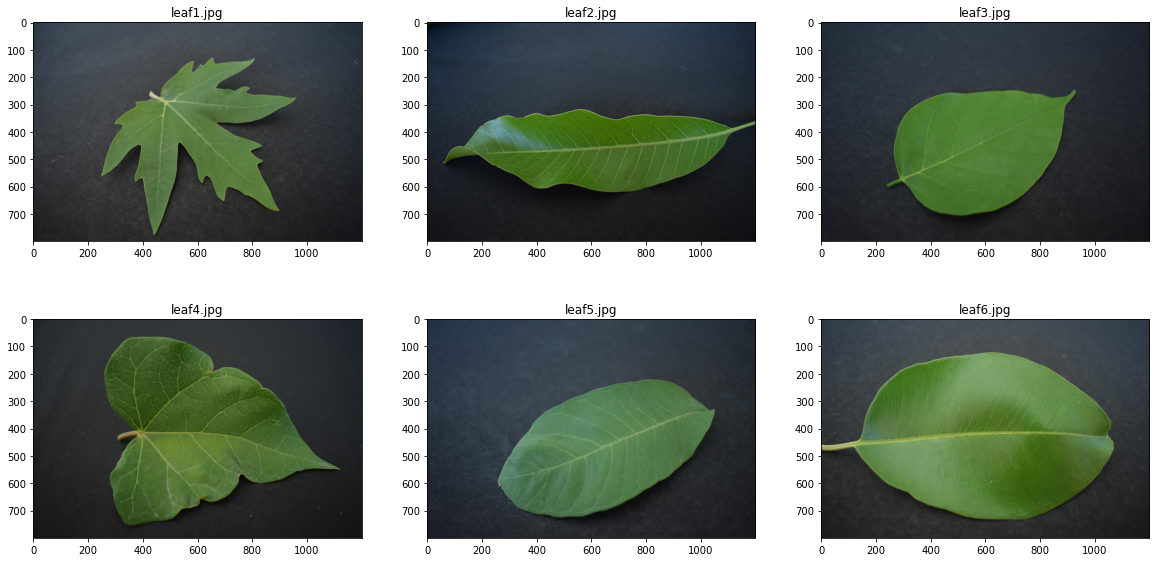

In [41]:
# Se cargan las imgánes
nimages = 6
    
filenames = [("leaf"+str(x)+".jpg") for x in range(1,nimages+1)]
imgs = [io.imread(file) for file in filenames]
imgs_grayscale = [rgb2gray(img) for img in imgs]

imgs_per_row = 3
n_rows = int(nimages/imgs_per_row)

fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(imgs[(col+1)+((imgs_per_row)*row)-1],cmap='gray')
        axs[row,col].set_title(filenames[(col+1)+((imgs_per_row)*row)-1])
    



#### 2.- Pruebas con algoritmos de segmentación.
##### 2.1.- Watershed.

La primera prueba se realiza con el algoritmo watershed. En este intento lo que se persigue es una segmentación óptima con la menor sobresegmentación posible, guiando al algoritmo mediante marcadores creados por el usuario.

Tiempo empleado: 9.209457400000247 segundos


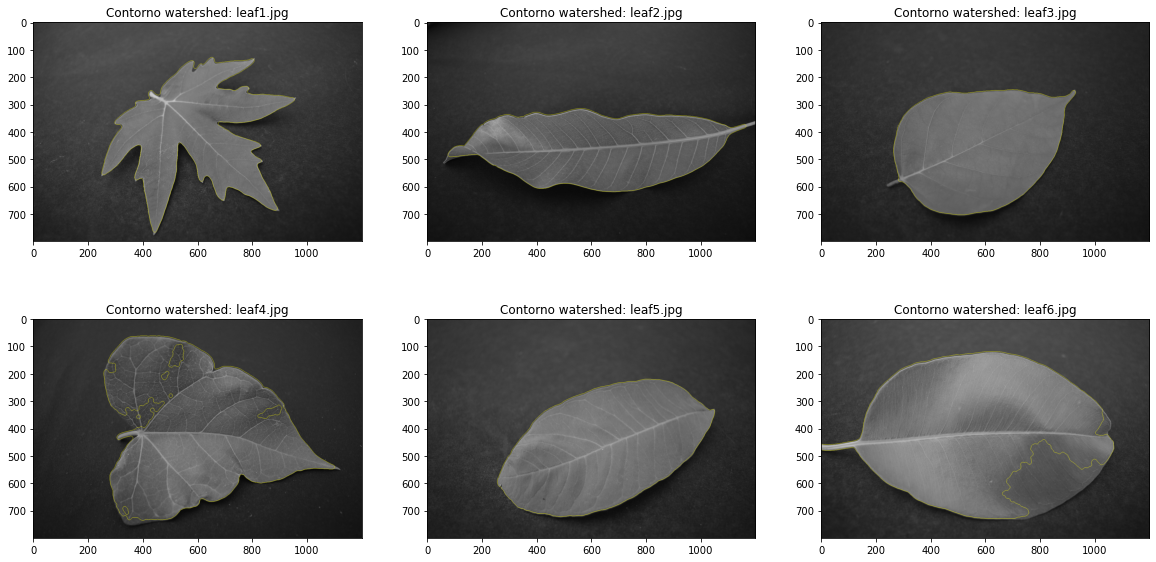

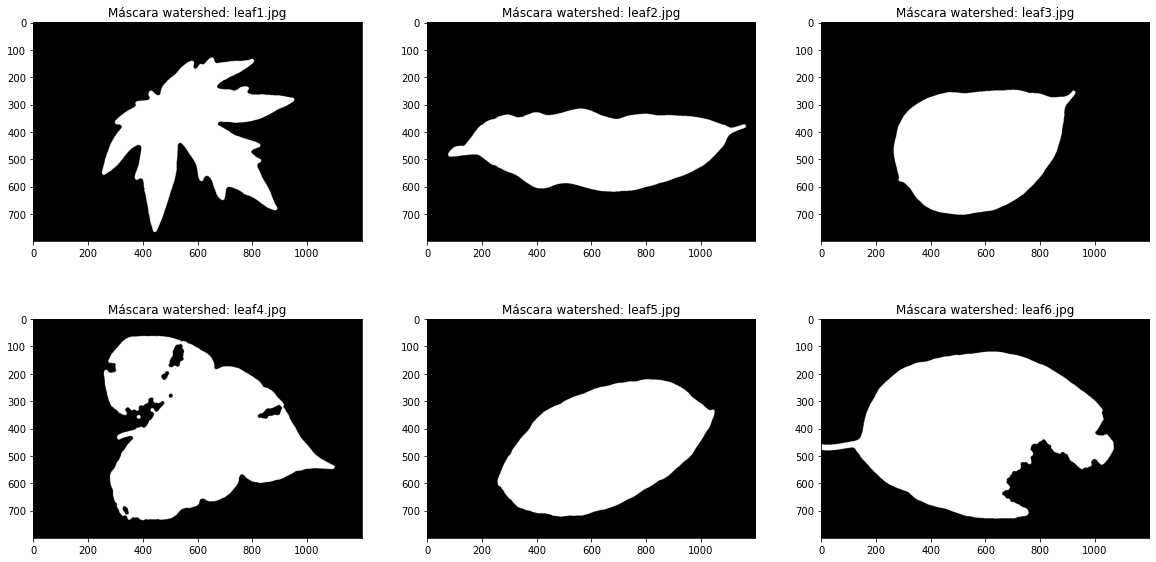

In [42]:
watershed_labels = []

t_init=time.perf_counter()

for img_grayscale in imgs_grayscale:
    # Primero se realiza un pequeño filtrado gaussiano para eliminar detalles
    gaussian_grayscale=gaussian(img_grayscale,sigma=3)
    # Se utiliza un filtro Sobel para acentuar los bordes, creando el mapa topográfico
    elevation_map = sobel(gaussian_grayscale)
    # Se genera un umbral para crear los marcadores
    thr=threshold_otsu(gaussian_grayscale)
    markers = np.zeros_like(gaussian_grayscale)

    markers[gaussian_grayscale < thr] = 0
    markers[gaussian_grayscale > thr] = 1
    # Se aplica apertura y cierre para quitar ruido impulsivo de la imagen umbralizada
    markers = morphology.opening(markers,morphology.disk(7))
    markers = morphology.closing(markers,morphology.disk(7))
    
    markers[markers == 1] = 2
    markers[markers == 0] = 1
    
    # Se aplica el algoritmo
    watershed_label = watershed(elevation_map, markers)
    # Se normalizan la etiquetas para que el BG sea 0 y el FG 1
    watershed_label[watershed_label==1] = 0
    watershed_label[watershed_label>1] = 1
    watershed_labels.append(watershed_label)

t_ws = time.perf_counter()-t_init

print("Tiempo empleado:",t_ws, "segundos")

# Se pinta la imagen con los contornos que representan el resultado de la segmentación    
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(mark_boundaries(imgs_grayscale[(col+1)+((imgs_per_row)*row)-1], watershed_labels[(col+1)+((imgs_per_row)*row)-1]),cmap='gray')
        axs[row,col].set_title("Contorno watershed: " + filenames[(col+1)+((imgs_per_row)*row)-1])
# Se pintan las máscaras obtenidas
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(watershed_labels[(col+1)+((imgs_per_row)*row)-1],cmap='gray')
        axs[row,col].set_title("Máscara watershed: " + filenames[(col+1)+((imgs_per_row)*row)-1])
    

**Observaciones:** la segmentación se ve limitada por la calidad de los marcadores, aunque el tiempo utilizado es bajo.

##### 2.2.- Watershed con grafos.

Se vuelve a probar el algoritmo watershed, pero en esta ocasión se va a prescindir de los marcadores predefinidos y en su lugar se le indicará un número moderadamente elevado de marcadores que el algoritmo decidirá. A continuación se agruparán los segmentos mediante segmentación basada en grafos, dado que se espera sobresegmentación.

Tiempo empleado: 35.959350500001165 segundos


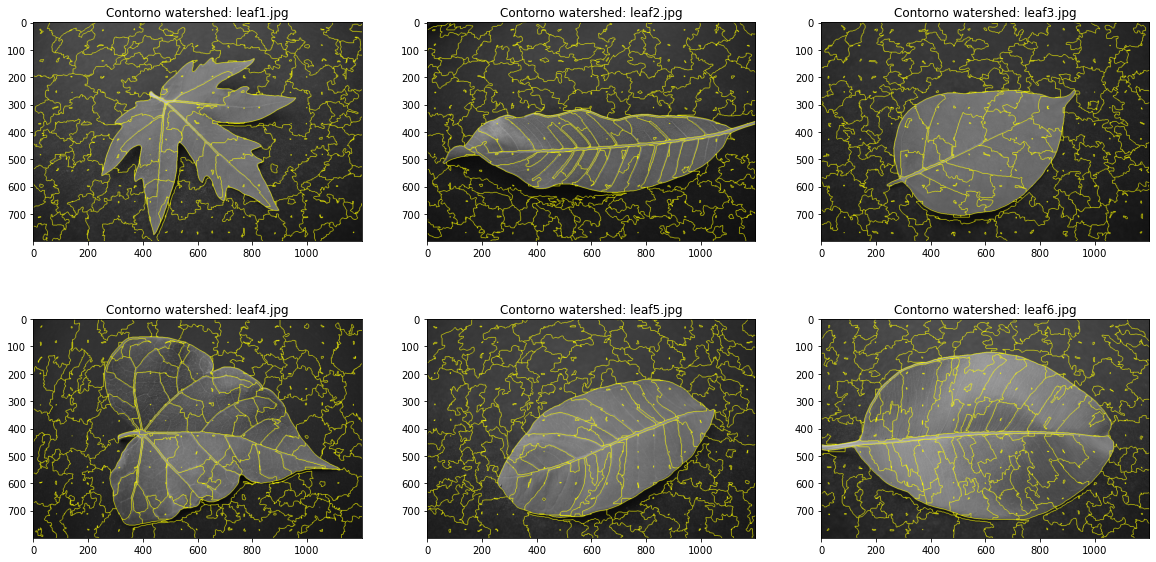

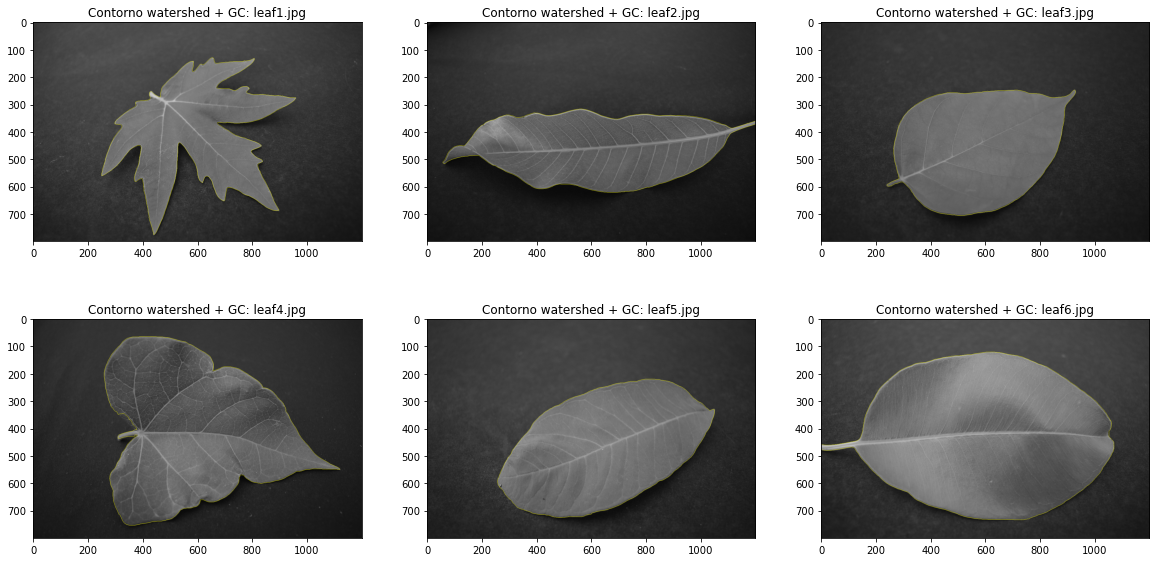

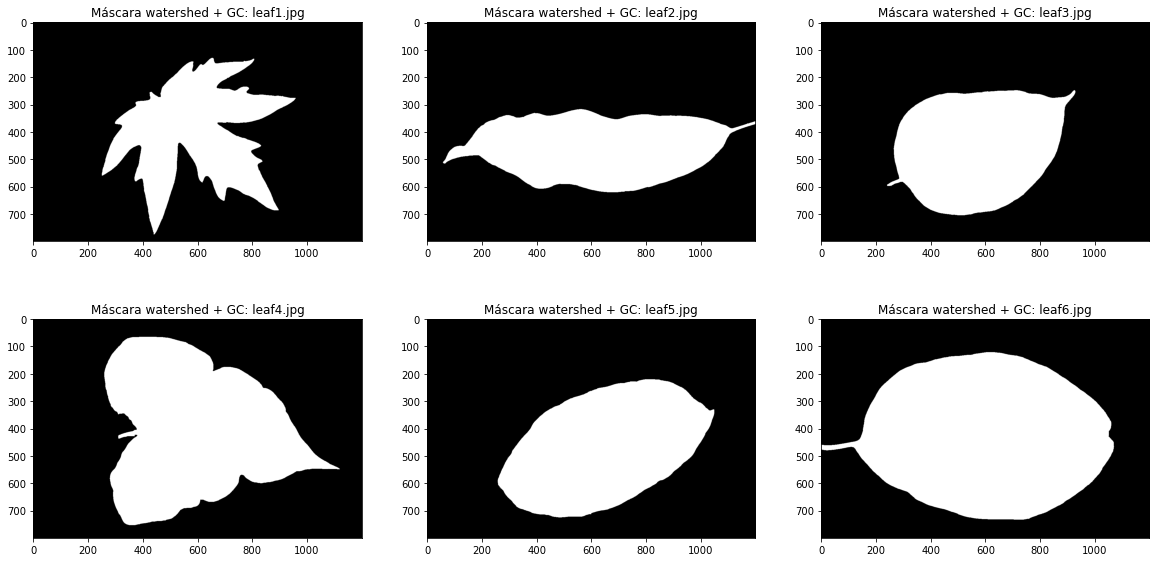

In [43]:
watershed_labels2 = []
normalized_labels = []

t_init=time.perf_counter()

for i in range(0,len(imgs_grayscale)):
    img_grayscale = imgs_grayscale[i]
    img = imgs[i]
    # Primero se realiza un pequeño filtrado gaussiano para eliminar detalles
    gaussian_grayscale=gaussian(img_grayscale,sigma=3)
    # Se utiliza un filtro Sobel para acentuar los bordes, creando el mapa topográfico
    elevation_map = sobel(gaussian_grayscale)

    watershed_label = watershed(elevation_map, markers=300, compactness=0.000001)

    watershed_labels2.append(watershed_label)
    
    # Se aplica graph cut para recomponer los segmentos
    rag = graph.rag_mean_color(img, watershed_label, mode='similarity')
    normalized_label = graph.cut_normalized(watershed_label, rag,num_cuts=10)
    # Se normalizan la etiquetas para que el BG sea 0 y el FG 1
    normalized_label[normalized_label==1] = 0
    normalized_label[normalized_label>1] = 1
    
    normalized_labels.append(normalized_label)

t_wsgc = time.perf_counter()-t_init
 
print("Tiempo empleado:",t_wsgc, "segundos")
    
# Se pinta la imagen con los contornos que representan el resultado de la segmentación  con watershed  
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(mark_boundaries(imgs_grayscale[(col+1)+((imgs_per_row)*row)-1], watershed_labels2[(col+1)+((imgs_per_row)*row)-1]),cmap='gray')
        axs[row,col].set_title("Contorno watershed: " + filenames[(col+1)+((imgs_per_row)*row)-1])

# Se pinta la imagen con los contornos que representan el resultado de la segmentación tras el uso de graph cut      
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(mark_boundaries(imgs_grayscale[(col+1)+((imgs_per_row)*row)-1], normalized_labels[(col+1)+((imgs_per_row)*row)-1]),cmap='gray')
        axs[row,col].set_title("Contorno watershed + GC: " + filenames[(col+1)+((imgs_per_row)*row)-1])
        
# Se pintan las máscaras obtenidas        
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(normalized_labels[(col+1)+((imgs_per_row)*row)-1],cmap='gray')
        axs[row,col].set_title("Máscara watershed + GC: " + filenames[(col+1)+((imgs_per_row)*row)-1])

**Observaciones:** como se comentaba, se ha producido sobresegmentación, no obstante graph cut ha hecho una buena labor uniendo los segmentos.

##### 2.3.- Quickshift con grafos.

De manera similar al ejemplo anterior, se va a utilizar otro algoritmo de superpíxeles combinado con grafos para ver qué diferencias se pueden obtener en el resultado

Tiempo empleado: 84.29465329999948 segundos


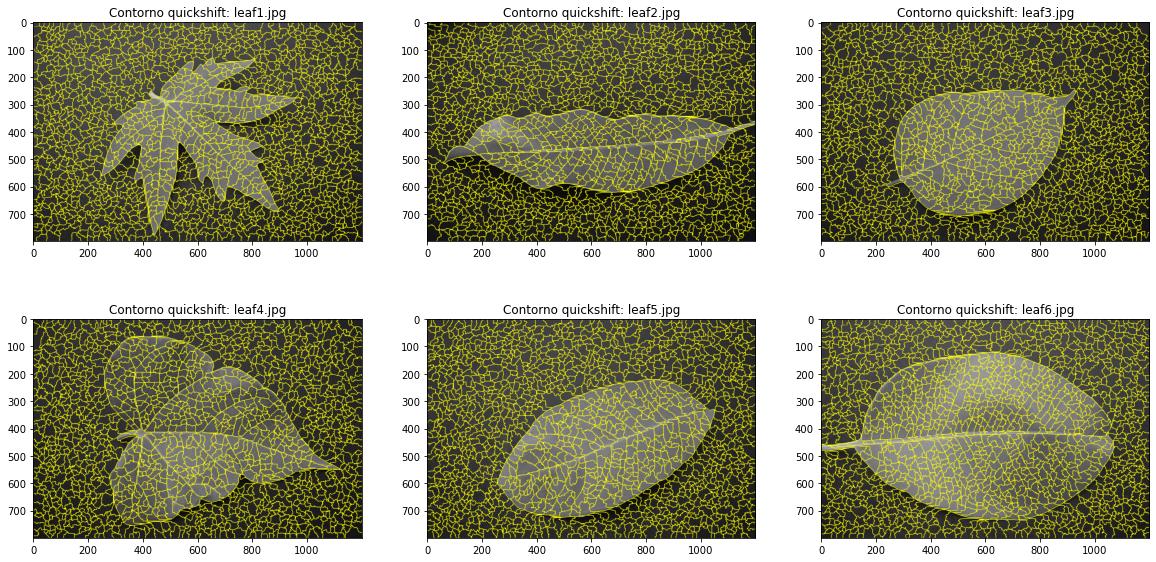

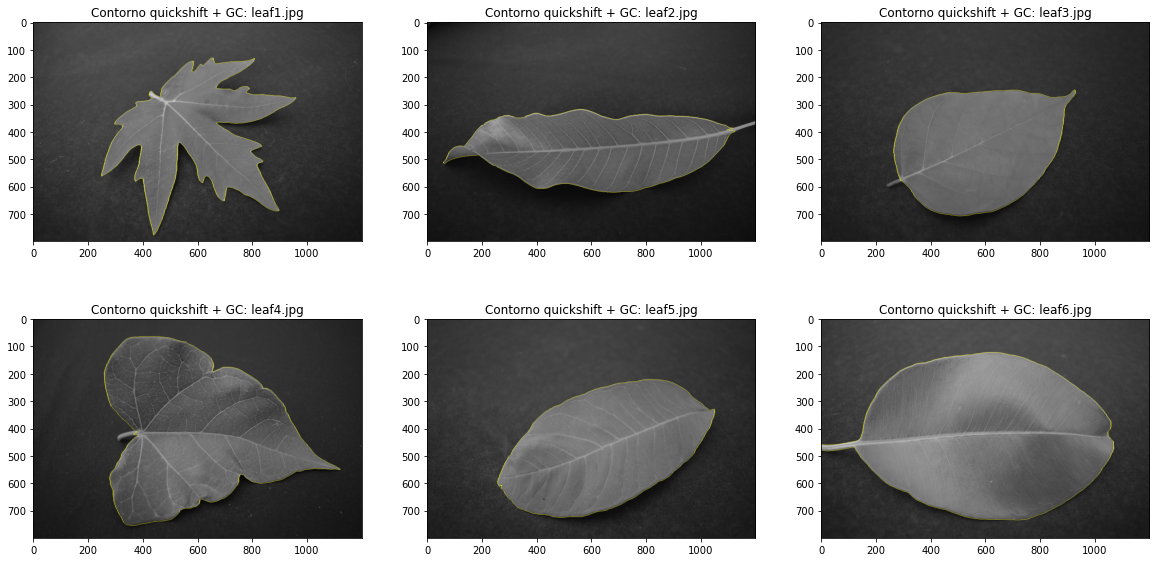

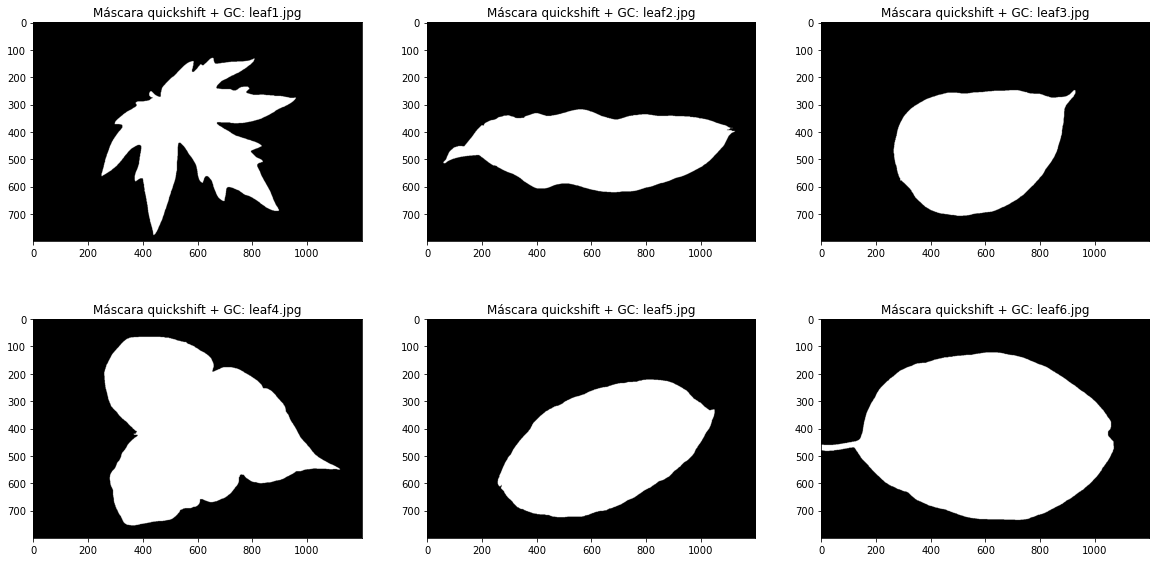

In [44]:
quickshift_labels = []
normalized_labels2 = []

t_init = time.perf_counter()

for img in imgs:
    # Se aplica el algoritmo sobre la imagen en color, aplicando al mismo tiempo el suavizado
    quickshift_label = quickshift(img, kernel_size=3, max_dist=100, ratio=0.5,sigma=1)
    
    quickshift_labels.append(quickshift_label)
    # Se aplica graph cut para recomponer los segmentos
    rag = graph.rag_mean_color(img, quickshift_label, mode='similarity')
    normalized_label = graph.cut_normalized(quickshift_label, rag,num_cuts=10)
    # Se normalizan la etiquetas para que el BG sea 0 y el FG 1
    normalized_label[normalized_label>0] = 1
    normalized_labels2.append(normalized_label)
    
t_qsgc = time.perf_counter()-t_init
    
print("Tiempo empleado:",t_qsgc, "segundos")

# Se pinta la imagen con los contornos que representan el resultado de la segmentación  con quickshift 
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(mark_boundaries(imgs_grayscale[(col+1)+((imgs_per_row)*row)-1], quickshift_labels[(col+1)+((imgs_per_row)*row)-1]),cmap='gray')
        axs[row,col].set_title("Contorno quickshift: " + filenames[(col+1)+((imgs_per_row)*row)-1])
        
# Se pinta la imagen con los contornos que representan el resultado de la segmentación tras el uso de graph cut
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(mark_boundaries(imgs_grayscale[(col+1)+((imgs_per_row)*row)-1], normalized_labels2[(col+1)+((imgs_per_row)*row)-1]),cmap='gray')
        axs[row,col].set_title("Contorno quickshift + GC: " + filenames[(col+1)+((imgs_per_row)*row)-1])
        
# Se pintan las máscaras obtenidas 
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(normalized_labels2[(col+1)+((imgs_per_row)*row)-1],cmap='gray')
        axs[row,col].set_title("Máscara quickshift + GC: " + filenames[(col+1)+((imgs_per_row)*row)-1])

**Observaciones:** en general se obtienen peores resultados que con watershed con graph cut incluso utilizando más segmentos, lo que a su vez dispara el tiempo que tardan en unirse los segmentos.

##### 2.4.- Contornos activos geodésicos.

Si se le diese el tiempo necesario, este algoritmo conseguiría adaptarse perfectamente a las hojas de las fotografías. En este ejemplo se busca un compromiso entre tiempo de ejecución y precsión en la segmentación con 500 iteraciones y el apoyo de un umbral que representa aproximadamente el valor de los bordes marcados por el gradiente gaussiano aplicado en el preprocesamiento.

Tiempo empleado: 561.930583100002 segundos


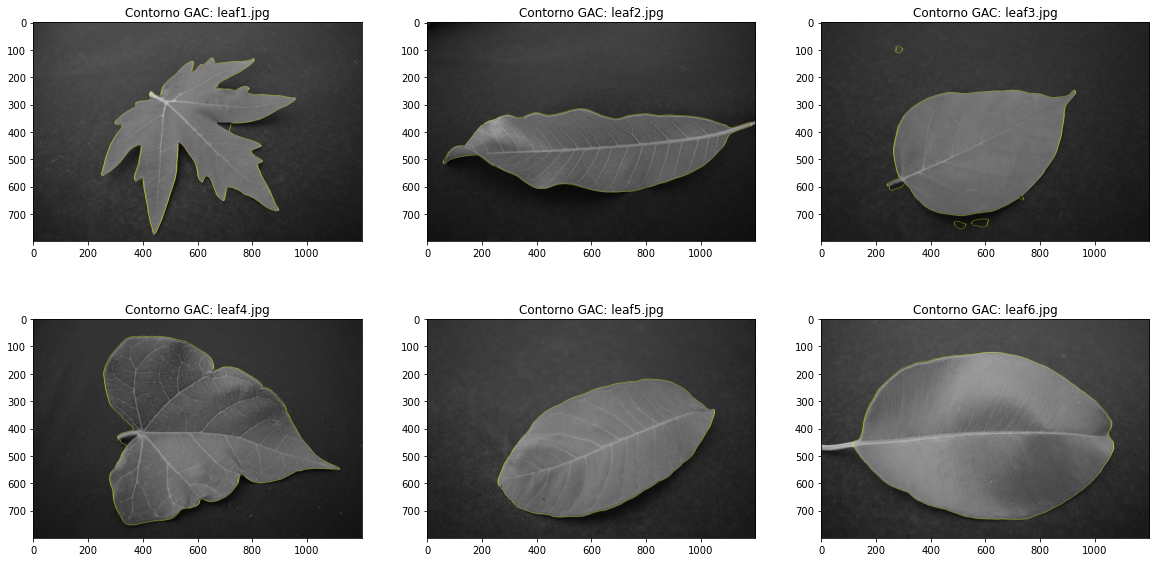

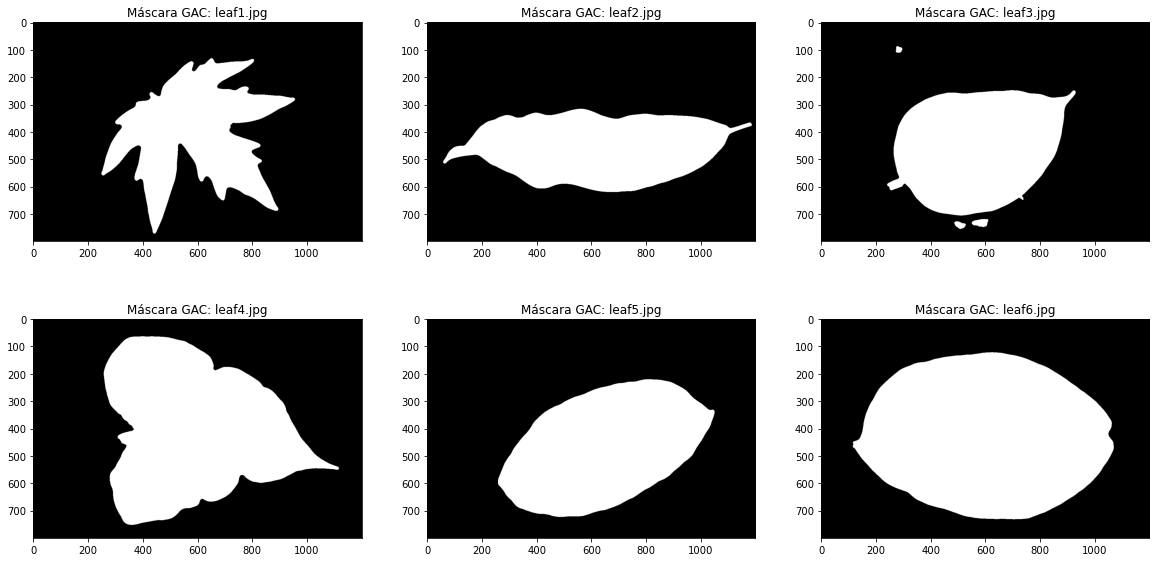

In [45]:
gac_labels=[]

t_init = time.perf_counter()

for img_grayscale in imgs_grayscale:
    # Se calcula el gradiente inverso con suavizado
    gradient = inverse_gaussian_gradient(img_as_float(img_grayscale),sigma=6,alpha=500)
    # Se define la inicialización para el agoritmo como un marco
    init_ls = np.zeros(img_grayscale.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    
    # Se aplica el agoritmo
    gac_label = morphological_geodesic_active_contour(gradient, iterations=500,
                                                      init_level_set=init_ls,
                                                      smoothing=3, threshold=np.quantile(gradient, 0.1),balloon=-1)

    gac_label = label(gac_label)
    # Se nor malizan las etiquetas para que 0 sea BG y 1 FG
    gac_label[gac_label>0] = 1
    gac_labels.append(gac_label)

t_gac = time.perf_counter()-t_init
    
print("Tiempo empleado:",t_gac, "segundos")
    
# Se pinta la imagen con los contornos que representan el resultado de la segmentación    
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(mark_boundaries(imgs_grayscale[(col+1)+((imgs_per_row)*row)-1], gac_labels[(col+1)+((imgs_per_row)*row)-1]),cmap='gray')
        axs[row,col].set_title("Contorno GAC: " + filenames[(col+1)+((imgs_per_row)*row)-1])
# Se pintan las máscaras obtenidas
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(gac_labels[(col+1)+((imgs_per_row)*row)-1],cmap='gray')
        axs[row,col].set_title("Máscara GAC: " + filenames[(col+1)+((imgs_per_row)*row)-1])

**Observaciones:** el resultado no es el mejor que se podría obtener con este algoritmo debido a la falta de iteraciones, pero en base a pruebas previas, se ve que el umbral ayuda mucho a mejorar la calidad de la segmentación sin invertir cantidades exageradas de tiempo. Este resultado equivaldría a la ejecución del algoritmo con 10 veces más iteraciones sin umbral y aún así ya consume bastante tiempo.

##### 2.5.- Simple linear interactive clustering (SLIC).

Con este algoritmo de segmentación por regiones se busca lo mismo que con el primer ejemplo de watershed, buscar una baja segmentación. Esto se facilita al poder definir el número de clústers de k-means.

Tiempo empleado: 14.029394899996987 segundos


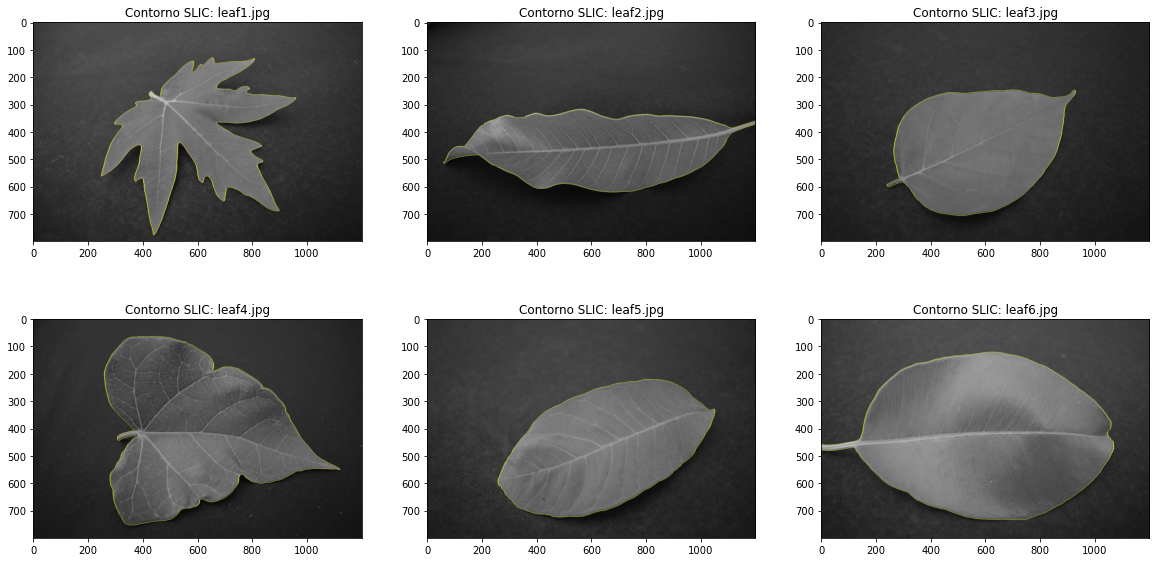

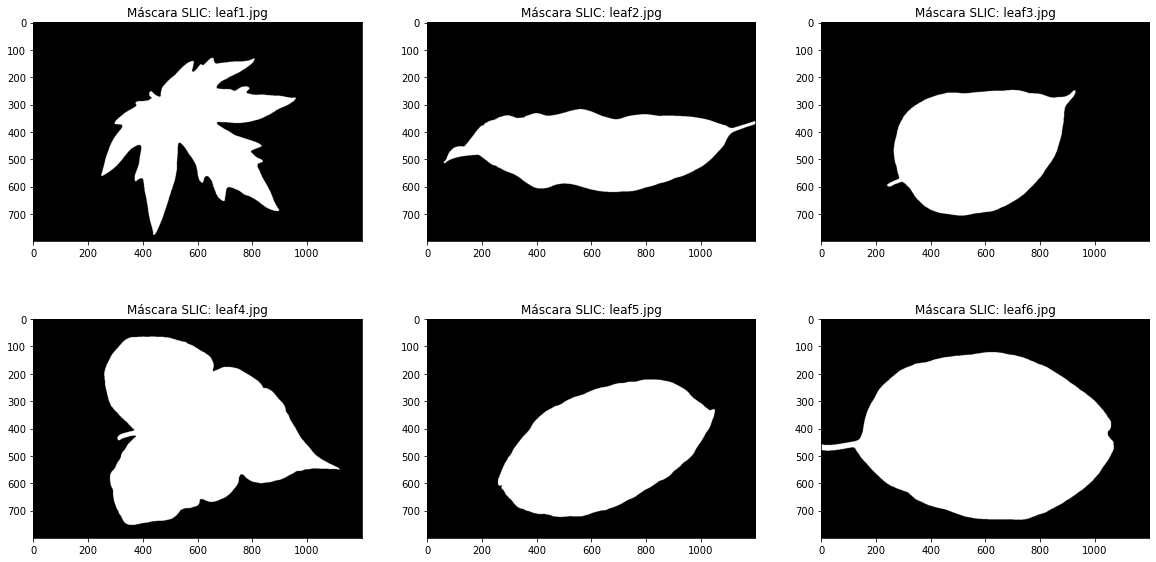

In [46]:
slic_labels = []

t_init = time.perf_counter()

#Se aplica el algoritmo sobre la imagen a color (se especifica suavizado con sigma)
for img in imgs:
    slic_label = segmentation.slic(img, compactness=20, n_segments=2,start_label=0,max_iter=100,sigma=2,min_size_factor=0.25)
    # Se normalizan las etiquetas para que 0 sea BG y 1 FG
    slic_label[slic_label>0] = 1
    slic_labels.append(slic_label)
    
t_slic = time.perf_counter()-t_init

print("Tiempo empleado:",t_slic, "segundos")

# Se pinta la imagen con los contornos que representan el resultado de la segmentación   
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(mark_boundaries(imgs_grayscale[(col+1)+((imgs_per_row)*row)-1], slic_labels[(col+1)+((imgs_per_row)*row)-1]),cmap='gray')
        axs[row,col].set_title("Contorno SLIC: " + filenames[(col+1)+((imgs_per_row)*row)-1])

# Se pintan las máscaras obtenidas        
fig1, axs = plt.subplots(ncols=imgs_per_row,nrows=n_rows,figsize=(20,10))
for row in range(0,n_rows):
    for col in range(0,imgs_per_row):
        axs[row,col].imshow(slic_labels[(col+1)+((imgs_per_row)*row)-1],cmap='gray')
        axs[row,col].set_title("Máscara SLIC: " + filenames[(col+1)+((imgs_per_row)*row)-1])


**Observaciones:** el hecho de que la imagen sea tan simple con dos regiones tan bien definidas, convierte este algoritmo basado en k-means en la mejor solución posible. Al definir dos clústers, el agoritmo se ha comportado exactamente como se deseaba. <br>

No se espera poder mejorar este resultado manualmente, por lo que será usado como ground truth para validar el resto de segmentadores

#### 3.- Evaluación de algoritmos.

Para la generación de métricas de validación, se define una función que genera las métricas a partir de la media aritmética de las métricas obtenidas para cada algoritmo en todo el set (las seis imágenes). La función compara las máscaras de ground truth y las generadas por los segmentadores para obtener la exactitud, precisión, recall y F1.

In [11]:
def get_metrics(ground_truth_set,predicted_set):
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(0,len(ground_truth_set)):
        accuracy.append(metrics.accuracy_score(np.ravel(ground_truth_set[i]),np.ravel(predicted_set[i])))
        precision.append(metrics.precision_score(np.ravel(ground_truth_set[i]),np.ravel(predicted_set[i])))
        recall.append(metrics.recall_score(np.ravel(ground_truth_set[i]),np.ravel(predicted_set[i])))
        f1.append(metrics.f1_score(np.ravel(ground_truth_set[i]),np.ravel(predicted_set[i])))
        
    return (sum(accuracy)/len(accuracy),sum(precision)/len(precision),sum(recall)/len(recall),sum(f1)/len(f1))
        
    
    

In [47]:
# Se definen las máscaras obtenidas con SLIC como ground truth
ground_truth = slic_labels

# Se compara el ground truth contra sí mismo a modo de test. Debería dar 1.0 para todas las métricas
slic_accuracy,slic_precision,slic_recall,slic_f1 = get_metrics(ground_truth,slic_labels)

print("Exactitud SLIC:",slic_accuracy)
print("Precisión SLIC:",slic_precision)
print("Recall SLIC:",slic_recall)
print("F1 SLIC:",slic_f1)
print()

# Se obtienen las métricas del segmentador watershed
watershed_accuracy,watershed_precision,watershed_recall,watershed_f1 = get_metrics(ground_truth,watershed_labels)

print("Exactitud watershed baja segmentación:",watershed_accuracy)
print("Precisión watershed baja segmentación:",watershed_precision)
print("Recall watershed baja segmentación:",watershed_recall)
print("F1 watershed:",watershed_f1)
print()

# Se obtienen las métricas del segmentador watershed con graph cut
watershedgcut_accuracy,watershedgcut_precision,watershedgcut_recall,watershedgcut_f1 = get_metrics(ground_truth,normalized_labels)

print("Exactitud watershed sobresegmentado + graph cut:",watershedgcut_accuracy)
print("Precisión watershed sobresegmentado + graph cut:",watershedgcut_precision)
print("Recall watershed sobresegmentado + graph cut:",watershedgcut_recall)
print("F1 watershed sobresegmentado + graph cut:",watershedgcut_f1)
print()

# Se obtienen las métricas del segmentador quickshift con graph cut
quickshift_accuracy,quickshift_precision,quickshift_recall,quickshift_f1 = get_metrics(ground_truth,normalized_labels2)

print("Exactitud quickshift sobresegmentado + graph cut:",quickshift_accuracy)
print("Precisión quickshift sobresegmentado + graph cut:",quickshift_precision)
print("Recall quickshift sobresegmentado + graph cut:",quickshift_recall)
print("F1 quickshift sobresegmentado + graph cut:",quickshift_f1)
print()

# Se obtienen las métricas del segmentador de contornos activos
gac_accuracy,gac_precision,gac_recall,gac_f1 = get_metrics(ground_truth,gac_labels)

print("Exactitud contornos activos:",gac_accuracy)
print("Precisión contornos activos:",gac_precision)
print("Recall contornos activos:",gac_recall)
print("F1 contornos activos:",gac_f1)
print()





Exactitud SLIC: 1.0
Precisión SLIC: 1.0
Recall SLIC: 1.0
F1 SLIC: 1.0

Exactitud watershed baja segmentación: 0.9833131944444444
Precisión watershed baja segmentación: 0.9930449421012607
Recall watershed baja segmentación: 0.9624017635110862
F1 watershed: 0.9768836848509813

Exactitud watershed sobresegmentado + graph cut: 0.998071875
Precisión watershed sobresegmentado + graph cut: 0.9963727456815922
Recall watershed sobresegmentado + graph cut: 0.9965848893287664
F1 watershed sobresegmentado + graph cut: 0.9964760877247621

Exactitud quickshift sobresegmentado + graph cut: 0.9982300347222223
Precisión quickshift sobresegmentado + graph cut: 0.997676781668584
Recall quickshift sobresegmentado + graph cut: 0.9958801393806057
F1 quickshift sobresegmentado + graph cut: 0.9967765592889927

Exactitud contornos activos: 0.9965564236111112
Precisión contornos activos: 0.9910629158069507
Recall contornos activos: 0.9966405667046038
F1 contornos activos: 0.9938346922899705



A continuación se muestran las siguientes gráficas
- Gráfica de dispersión de precisión frente a recall
- Gráfica de barras con los tiempos de ejecición de cada segmentador

Text(0.5, 1.0, 'Tiempos de ejecución')

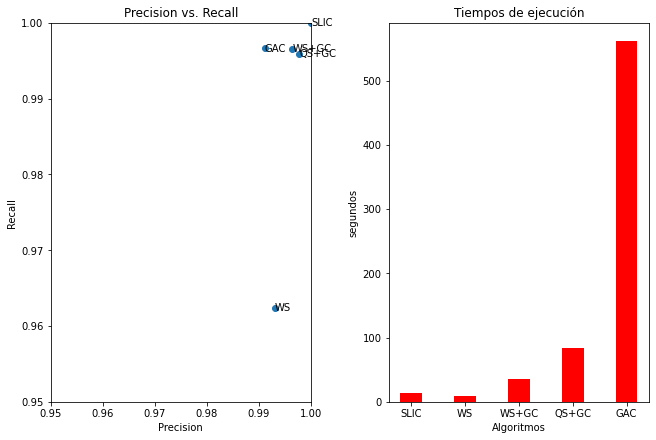

In [66]:
short_method_names = ["SLIC","WS","WS+GC","QS+GC","GAC"]
precision_list = [slic_precision,watershed_precision,watershedgcut_precision,quickshift_precision,gac_precision]
recall_list = [slic_recall,watershed_recall,watershedgcut_recall,quickshift_recall,gac_recall]
f1_list = [slic_f1,watershed_f1,watershedgcut_f1,quickshift_f1,gac_f1]
times = [t_slic,t_ws,t_wsgc,t_qsgc,t_gac]


fig, ax = plt.subplots(1, 2, figsize=(9, 6), constrained_layout=True)
axs = ax.ravel()


axs[0].scatter(precision_list, recall_list)
for i, txt in enumerate(short_method_names):
    axs[0].annotate(txt, (precision_list[i], recall_list[i]),
                   verticalalignment='center')
axs[0].set_xlabel('Precision')
axs[0].set_ylabel('Recall')
axs[0].set_title('Precision vs. Recall')
axs[0].set_xlim(0.95, 1)
axs[0].set_ylim(0.95, 1)

axs[1].bar(short_method_names, times, color ='red',  width = 0.4)
axs[1].set_xlabel('Algoritmos')
axs[1].set_ylabel('segundos')
axs[1].set_title('Tiempos de ejecución')


**Observaciones:** se ve que todos los segmentadores están bastante cercanos en cuanto a la captura correcta de ejemplos positivos y número de ejemplos positivos capturados, siendo watershed algo inferior, ya que como se ha visto las máscaras generadas por este método pueden contener artefactos debido a la calidad de los marcadores. Obviamente el agoritmo SLIC tiene una puntuación perfecta pues es el mismo ground truth, pero ya antes de realizar la evaluación se había decidido que el margen de mejora es despreciable y que no es posible obtener un ground truth mejor por ningún medio.<br>

Por otro lado, si se observan los tiempos de ejecución, se ve como el tiempo consumido por el segmentador de contornos activos es muy superior al resto, seguido por los algoritmos combinados con graph cut (mayor sobresegmentación, mayor tiempo de unión) y por último los segmentadores SLIC y watershed.

#### 4.- Conclusiones.

Como se ha visto, no todo gira en torno a la calidad de la segmentación, pues el tiempo que emplea el segmentador también es muy importante, sobre todo si se trata de una tirada larga de muestras. Al final las soluciones más efectivas han resultado ser las más simples y que menos tiempo emplean. Aunque la calidad de watershed sin sobresegmentar no es mala en términos generales, la desecharía porque algunos artefactos arruinan completamente la máscara. Por otro lado considero SLIC ideal para este caso de segmentación binaria pues,a parte de obtener un resultado difícilmente mejorable, el hecho de poder seleccionar el número de clústeres resulta muy cómodo al presentar las fotografías dos agrupaciones tan claras de colores.